** **Install Libraries** **

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install xgboost
!pip install lightgbm
!pip install catboost
!pip install imbalanced-learn
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.5 MB/s eta 0:00:00


**Import necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, roc_curve, precision_recall_curve,
                            average_precision_score, f1_score)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

**Set random seed for reproducibility**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

** Load the dataset**

In [ ]:
df = pd.read_csv('creditcard.csv')

**Initial data exploration**

In [ ]:


# Attempt to load the dataset properly
try:
    # Try reading with headers
    df = pd.read_csv('creditcard.csv', sep=',')

    # If only one column is loaded, it's likely the CSV wasn't parsed properly
    if df.shape[1] == 1:
        print("Detected improperly parsed CSV. Attempting to fix...")
        df = pd.read_csv('creditcard.csv', sep=',', header=None)
        df = df[0].str.split(',', expand=True)
        df.columns = ['Time'] + [f'V{i}' for i in range(1, 29)] + ['Amount', 'Class']
except Exception as e:
    print("Failed to load CSV:", e)
    exit()

# Basic exploration
print(f"✅ Dataset shape: {df.shape}")

print("\n✅ First 5 rows:")
print(df.head())

print("\n✅ Data types and missing values:")
print(df.info())

print("\n✅ Class distribution:")
print(df['Class'].value_counts(normalize=True))

print("\n✅ Basic statistics:")
print(df.describe())


Detected improperly parsed CSV. Attempting to fix...
✅ Dataset shape: (18855, 31)

✅ First 5 rows:
   Time            V1            V2           V3            V4            V5  \
0  Time            V1            V2           V3            V4            V5   
1     0  -1.359807134  -0.072781173  2.536346738   1.378155224   -0.33832077   
2     0   1.191857111   0.266150712  0.166480113   0.448154078   0.060017649   
3     1  -1.358354062  -1.340163075  1.773209343   0.379779593  -0.503198133   
4     1  -0.966271712  -0.185226008   1.79299334  -0.863291275   -0.01030888   

             V6            V7           V8            V9  ...           V21  \
0            V6            V7           V8            V9  ...           V21   
1   0.462387778   0.239598554  0.098697901    0.36378697  ...  -0.018306778   
2  -0.082360809  -0.078802983  0.085101655  -0.255425128  ...  -0.225775248   
3   1.800499381   0.791460956  0.247675787  -1.514654323  ...   0.247998153   
4   1.247203168    0.2376

**Data Visualization**

In [ ]:
plt.figure(figsize=(15, 12))

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

**Class distribution**

Text(0.5, 1.0, 'Class Distribution (0: Legitimate, 1: Fraud)')

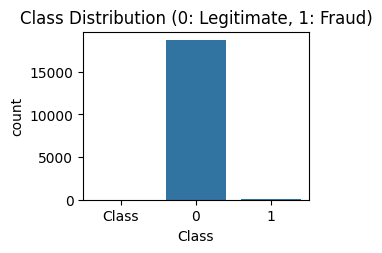

In [ ]:
plt.subplot(2, 2, 1)
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Legitimate, 1: Fraud)')

**Transaction amount distribution**

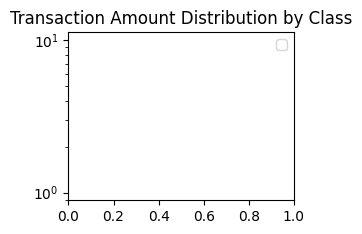

In [ ]:
plt.subplot(2, 2, 2)
sns.histplot(df[df['Class'] == 0]['Amount'], bins=50, color='blue', label='Legitimate', kde=True)
sns.histplot(df[df['Class'] == 1]['Amount'], bins=50, color='red', label='Fraud', kde=True)
plt.legend()
plt.title('Transaction Amount Distribution by Class')
plt.yscale('log')

** Time vs Amount by Class**

Text(0.5, 1.0, 'Time vs Amount by Class')

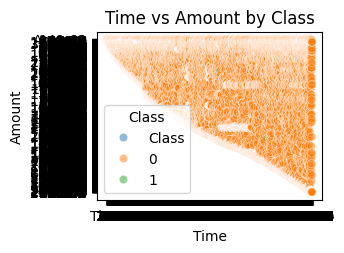

In [ ]:
plt.subplot(2, 2, 3)
sns.scatterplot(x='Time', y='Amount', hue='Class', data=df, alpha=0.5)
plt.title('Time vs Amount by Class')

**Correlation matrix**

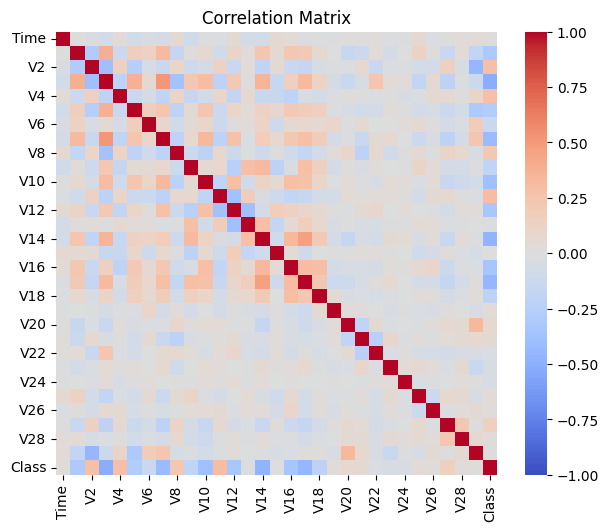

In [ ]:

# Ensure all columns are numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Optional: Drop rows with NaNs introduced by coercion
df.dropna(inplace=True)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 4)
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


# **Feature Engineering**

**Create time-based features (hours, day/night)**

In [ ]:
df['Hour'] = df['Time'] % (24 * 3600) // 3600
df['DayNight'] = df['Hour'].apply(lambda x: 1 if 6 <= x <= 18 else 0)  # 1 for day, 0 for night

**Create amount-related features**

In [ ]:
df['Amount_log'] = np.log1p(df['Amount'])
df['Amount_scaled'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

**Drop original Time and Amount columns**

In [ ]:
df.drop(['Time', 'Amount'], axis=1, inplace=True)

**Check class imbalance**

In [ ]:
print("\nClass distribution after feature engineering:")
print(df['Class'].value_counts(normalize=True))


Class distribution after feature engineering:
Class
0.0    0.995491
1.0    0.004509
Name: proportion, dtype: float64


**Prepare data for modelingt**

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

**Split data into train and test sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Scale the data (using RobustScaler due to potential outliers)**

In [ ]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

** Define evaluation function**

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # Evaluation metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC AUC Score: {roc_auc:.4f}")
    # Precision-Recall AUC
    pr_auc = average_precision_score(y_test, y_pred_proba)
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

**Train and evaluate a model**

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3754
         1.0       0.81      0.76      0.79        17

    accuracy                           1.00      3771
   macro avg       0.91      0.88      0.89      3771
weighted avg       1.00      1.00      1.00      3771


Confusion Matrix:
[[3751    3]
 [   4   13]]

ROC AUC Score: 0.9379
Precision-Recall AUC: 0.7860
F1 Score: 0.7879


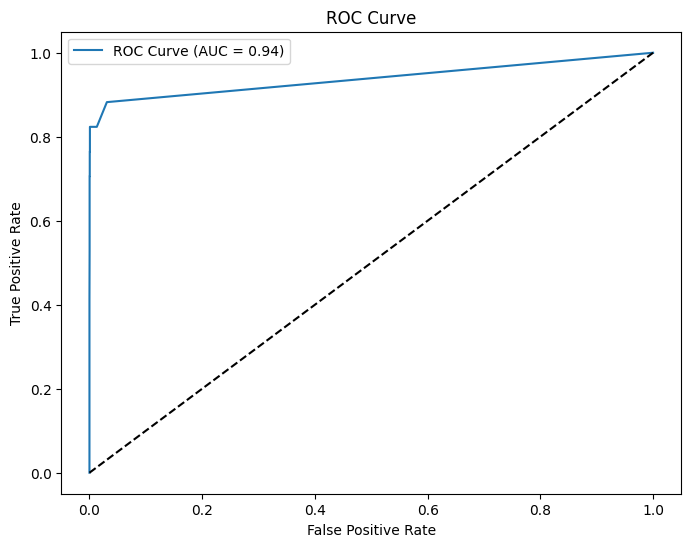

In [ ]:
model = RandomForestClassifier(random_state=42)
evaluate_model(model, X_train, y_train, X_test, y_test)

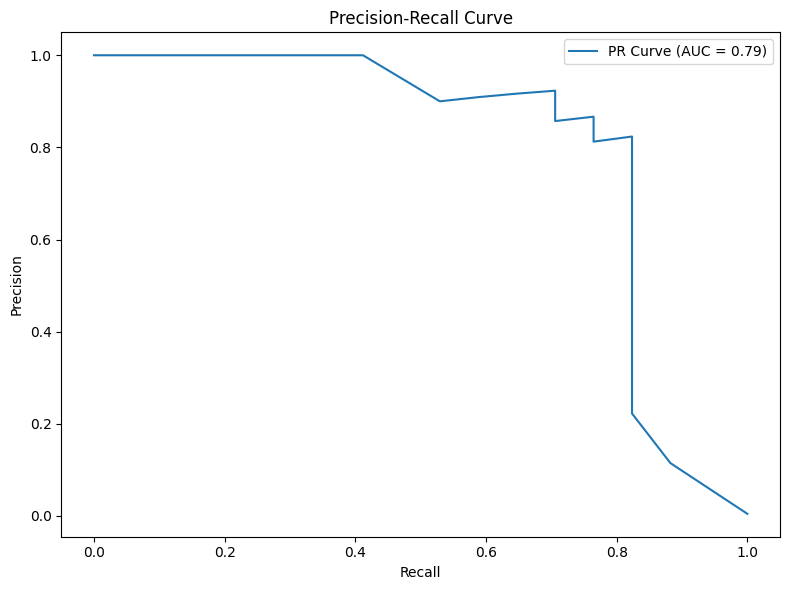

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming model is already trained
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute PR Curve values
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()



=== Logistic Regression ===
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      3754
         1.0       0.35      0.76      0.48        17

    accuracy                           0.99      3771
   macro avg       0.68      0.88      0.74      3771
weighted avg       1.00      0.99      0.99      3771


Confusion Matrix:
[[3730   24]
 [   4   13]]

ROC AUC Score: 0.8878
Precision-Recall AUC: 0.5926
F1 Score: 0.4815


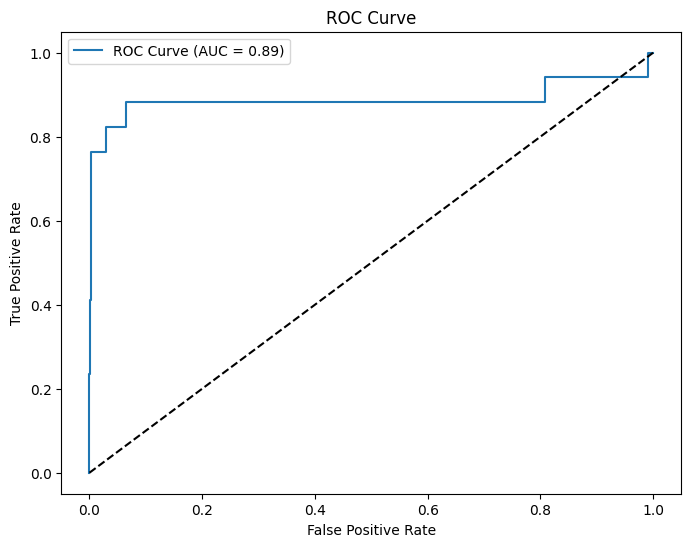


=== Random Forest ===
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3754
         1.0       0.80      0.71      0.75        17

    accuracy                           1.00      3771
   macro avg       0.90      0.85      0.87      3771
weighted avg       1.00      1.00      1.00      3771


Confusion Matrix:
[[3751    3]
 [   5   12]]

ROC AUC Score: 0.9388
Precision-Recall AUC: 0.7797
F1 Score: 0.7500


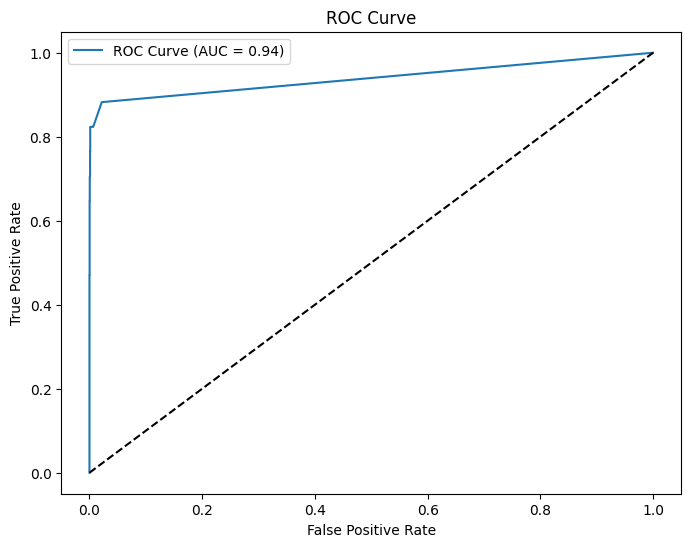


=== XGBoost with Class Weight ===
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3754
         1.0       0.72      0.76      0.74        17

    accuracy                           1.00      3771
   macro avg       0.86      0.88      0.87      3771
weighted avg       1.00      1.00      1.00      3771


Confusion Matrix:
[[3749    5]
 [   4   13]]

ROC AUC Score: 0.9933
Precision-Recall AUC: 0.8340
F1 Score: 0.7429


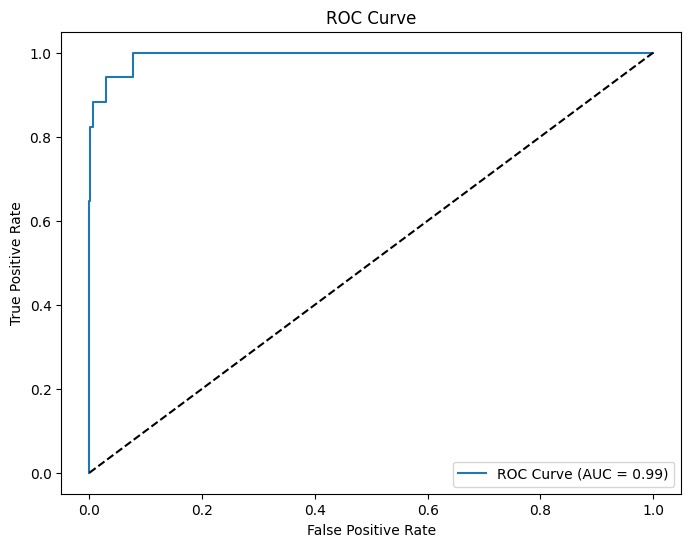


=== LightGBM with Class Weight ===
[LightGBM] [Info] Number of positive: 68, number of negative: 15013
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7661
[LightGBM] [Info] Number of data points in the train set: 15081, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

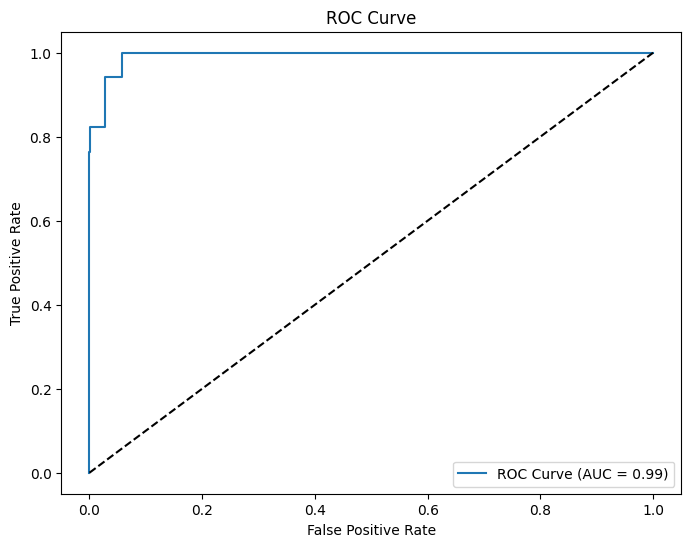


=== CatBoost with Class Weight ===
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3754
         1.0       0.74      0.82      0.78        17

    accuracy                           1.00      3771
   macro avg       0.87      0.91      0.89      3771
weighted avg       1.00      1.00      1.00      3771


Confusion Matrix:
[[3749    5]
 [   3   14]]

ROC AUC Score: 0.9949
Precision-Recall AUC: 0.8416
F1 Score: 0.7778


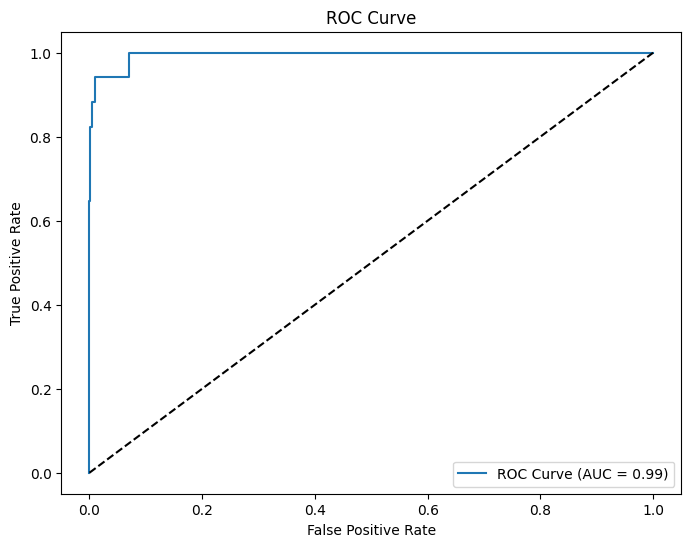

In [ ]:
# Baseline Models
print("\n=== Logistic Regression ===")
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr = evaluate_model(lr, X_train_scaled, y_train, X_test_scaled, y_test)

print("\n=== Random Forest ===")
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf = evaluate_model(rf, X_train_scaled, y_train, X_test_scaled, y_test)

# Advanced Models with Class Imbalance Handling
print("\n=== XGBoost with Class Weight ===")
xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
                    random_state=42, eval_metric='aucpr')
xgb = evaluate_model(xgb, X_train_scaled, y_train, X_test_scaled, y_test)

print("\n=== LightGBM with Class Weight ===")
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm = evaluate_model(lgbm, X_train_scaled, y_train, X_test_scaled, y_test)

print("\n=== CatBoost with Class Weight ===")
cat = CatBoostClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
                         random_state=42, verbose=0)
cat = evaluate_model(cat, X_train_scaled, y_train, X_test_scaled, y_test)

**Ensemble Approach**

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Initialize each classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
lgbm = LGBMClassifier(verbose=-1)
cat = CatBoostClassifier(verbose=0)



=== Voting Classifier ===
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3754
         1.0       0.68      0.76      0.72        17

    accuracy                           1.00      3771
   macro avg       0.84      0.88      0.86      3771
weighted avg       1.00      1.00      1.00      3771


Confusion Matrix:
[[3748    6]
 [   4   13]]

ROC AUC Score: 0.9838
Precision-Recall AUC: 0.6796
F1 Score: 0.7222


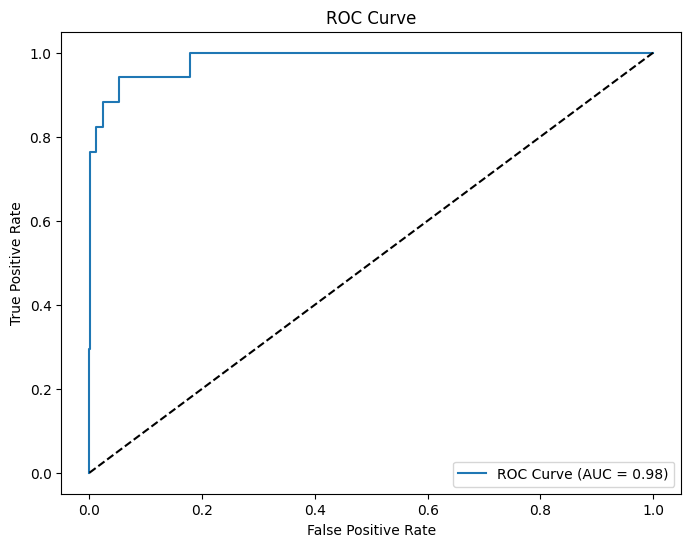

In [ ]:
from sklearn.ensemble import VotingClassifier

print("\n=== Voting Classifier ===")
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('lgbm', lgbm),
    ('cat', cat)
], voting='soft')

voting_clf = evaluate_model(voting_clf, X_train_scaled, y_train, X_test_scaled, y_test)


**Neural Network Approach**

In [ ]:

print("\n=== Neural Network ===")
def create_nn_model(input_shape):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['AUC', 'Precision', 'Recall'])
    return model





=== Neural Network ===


**Class weights for NN**

In [ ]:

class_weight = {0: 1, 1: len(y_train[y_train==0])/len(y_train[y_train==1])}

**Create and train the model**

In [ ]:

nn_model = create_nn_model(X_train_scaled.shape[1])
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=256,
    class_weight=class_weight,
    verbose=1
)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - AUC: 0.8477 - Precision: 0.0098 - Recall: 0.8763 - loss: 1.2181 - val_AUC: 0.8118 - val_Precision: 0.5455 - val_Recall: 0.7059 - val_loss: 0.4300
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.8814 - Precision: 0.0454 - Recall: 0.8622 - loss: 0.9460 - val_AUC: 0.8526 - val_Precision: 0.6000 - val_Recall: 0.7059 - val_loss: 0.2916
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8971 - Precision: 0.1349 - Recall: 0.8189 - loss: 1.0077 - val_AUC: 0.8780 - val_Precision: 0.5909 - val_Recall: 0.7647 - val_loss: 0.2626
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.9760 - Precision: 0.1489 - Recall: 0.9124 - loss: 0.4678 - val_AUC: 0.8801 - val_Precision: 0.5000 - val_Recall: 0.7647 - val_loss: 0.1839
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9371 - Precision: 0.2302 - Recall: 0.9006 - loss: 0.9213 - val_AUC: 0.8814 - val_Precision: 0.3714 - val_Recall: 0.7647 - val_loss: 0.1386
Epoch 6/5

In [ ]:
print(history.history.keys())


dict_keys(['AUC', 'Precision', 'Recall', 'loss', 'val_AUC', 'val_Precision', 'val_Recall', 'val_loss'])


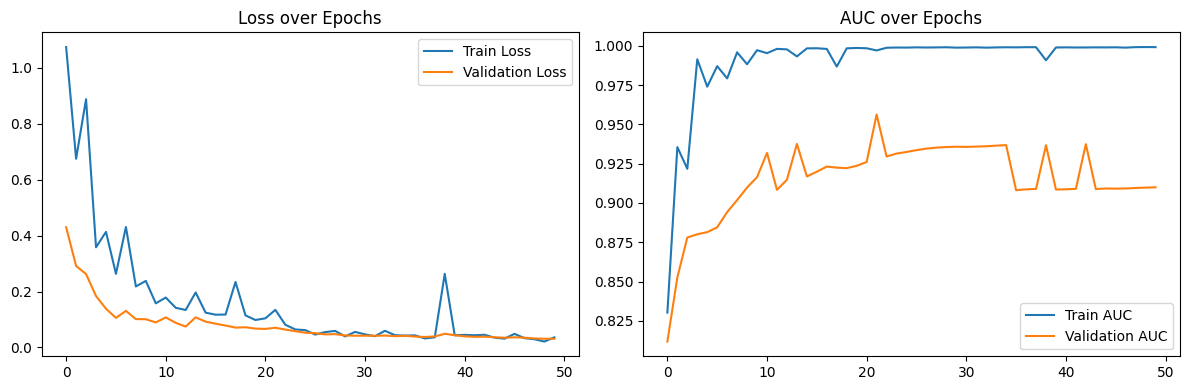

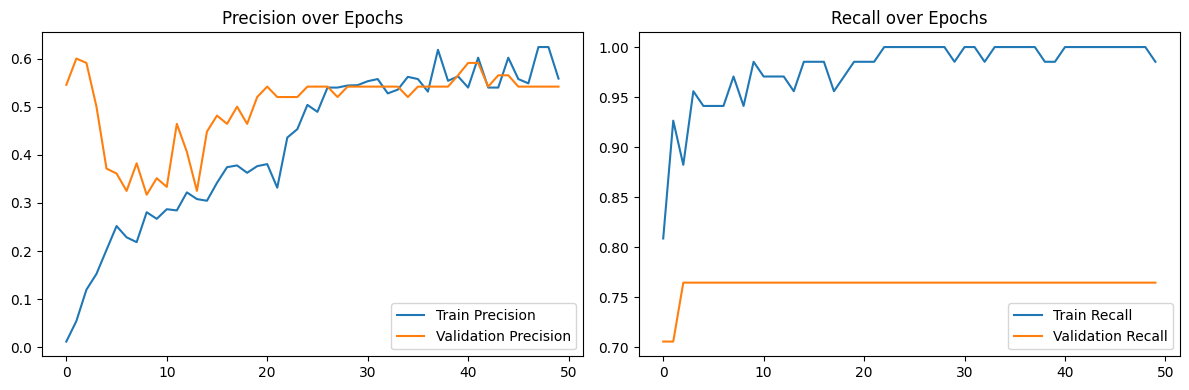

In [ ]:
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.legend()
plt.title('AUC over Epochs')

plt.tight_layout()
plt.show()

# Plot Precision
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['Precision'], label='Train Precision')
plt.plot(history.history['val_Precision'], label='Validation Precision')
plt.legend()
plt.title('Precision over Epochs')

# Plot Recall
plt.subplot(1, 2, 2)
plt.plot(history.history['Recall'], label='Train Recall')
plt.plot(history.history['val_Recall'], label='Validation Recall')
plt.legend()
plt.title('Recall over Epochs')

plt.tight_layout()
plt.show()



**Evaluate NN**

In [ ]:

y_pred_proba_nn = nn_model.predict(X_test_scaled).ravel()
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_nn))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

roc_auc_nn = roc_auc_score(y_test, y_pred_proba_nn)
print(f"\nROC AUC Score: {roc_auc_nn:.4f}")

pr_auc_nn = average_precision_score(y_test, y_pred_proba_nn)
print(f"Precision-Recall AUC: {pr_auc_nn:.4f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3754
         1.0       0.57      0.76      0.65        17

    accuracy                           1.00      3771
   macro avg       0.78      0.88      0.82      3771
weighted avg       1.00      1.00      1.00      3771


Confusion Matrix:
[[3744   10]
 [   4   13]]

ROC AUC Score: 0.9046
Precision-Recall AUC: 0.7568


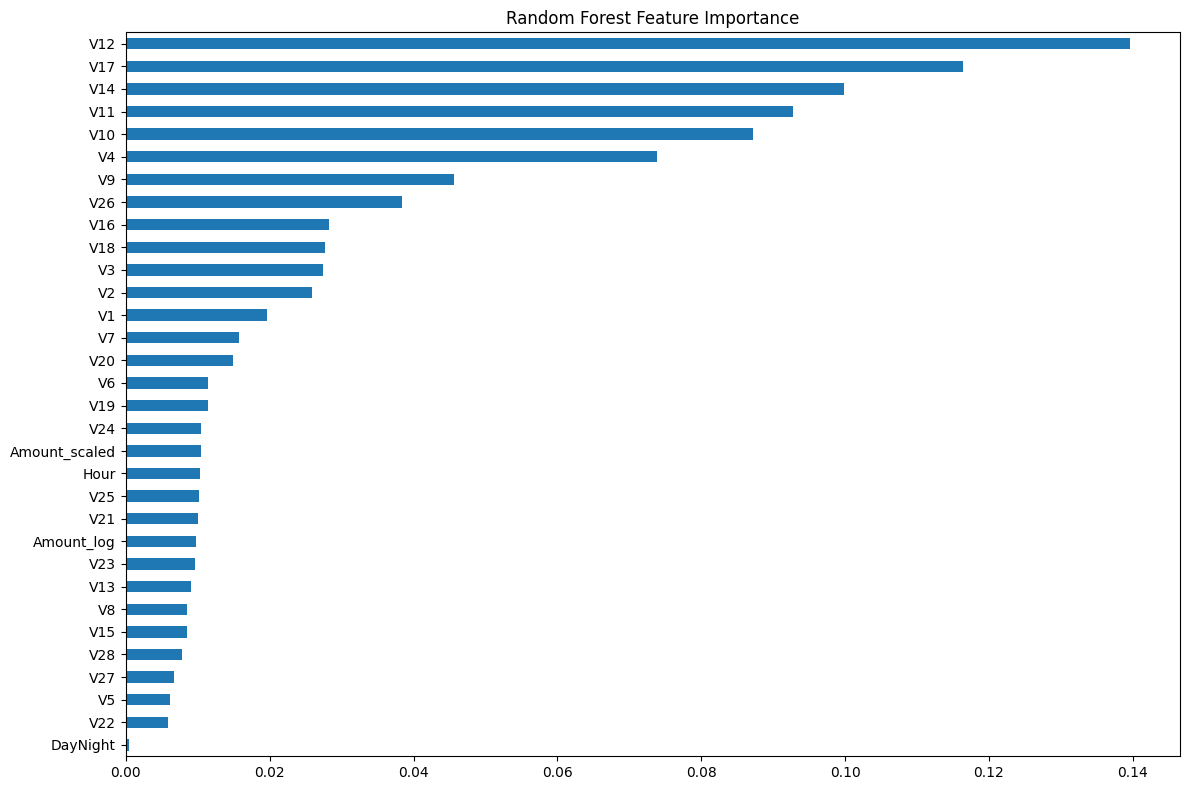

In [ ]:
# Train RF on original data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Feature importance
plt.figure(figsize=(12, 8))
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


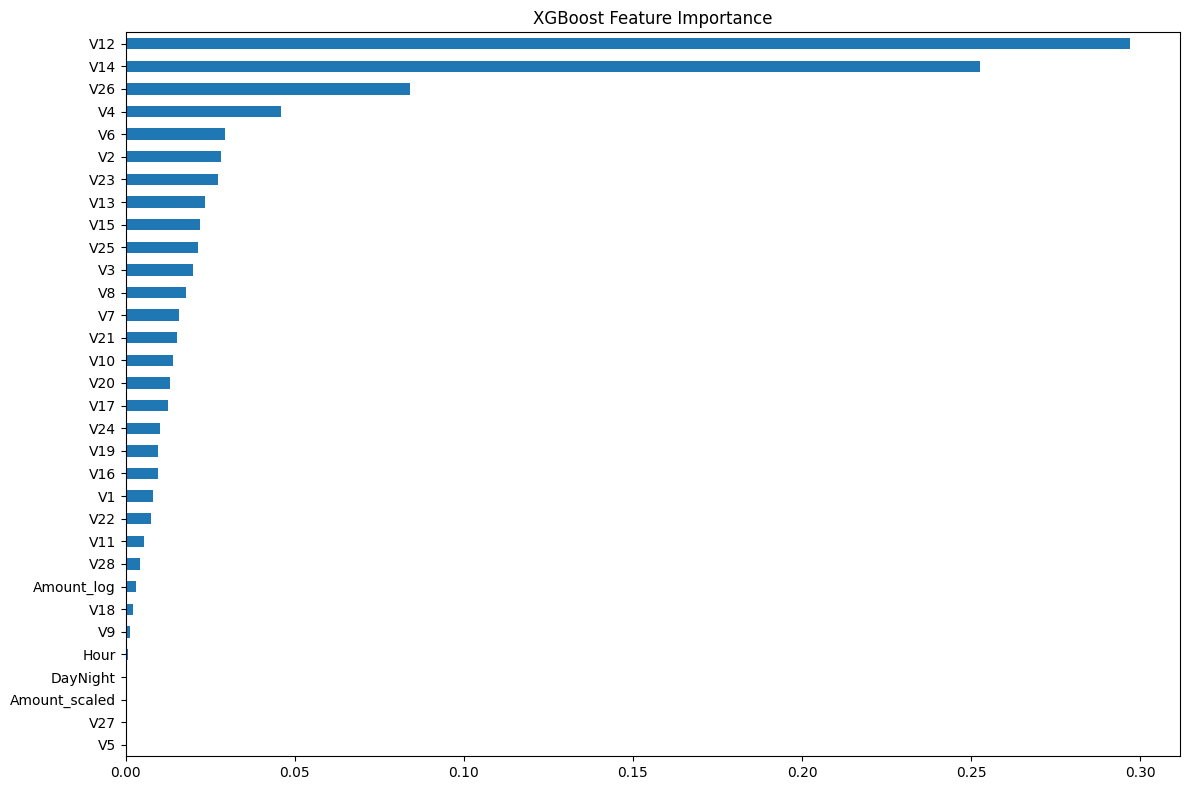

In [ ]:
# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)

# Feature Importance Plot
plt.figure(figsize=(12, 8))
pd.Series(xgb.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Define the classifiers
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgbm = LGBMClassifier(random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

# Create Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('xgb', xgb), ('lgbm', lgbm), ('cat', cat)],
    voting='soft'
)

# Train the Voting Classifier
voting_clf.fit(X_train_scaled, y_train)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lgbm', LGBMClassifier(random_state=42)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7ebbe71d6850>)],
                 voting='soft')


=== Threshold Optimization ===


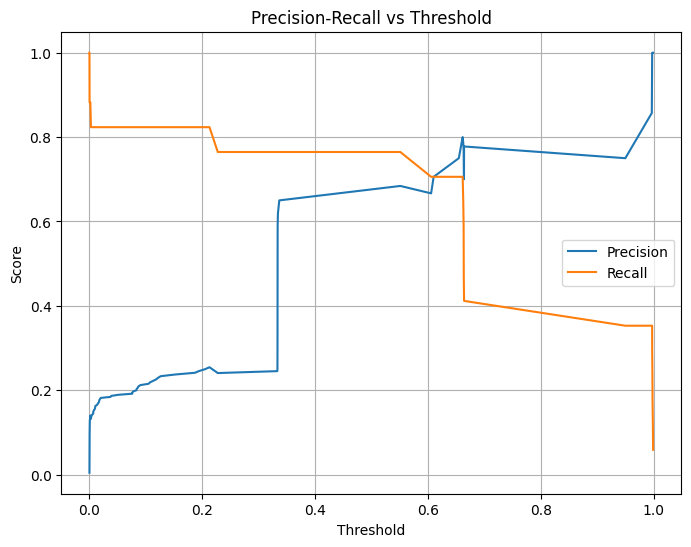

In [ ]:
from sklearn.metrics import precision_recall_curve

print("\n=== Threshold Optimization ===")

# Predict probabilities
y_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]

# Compute Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Find threshold that maximizes F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold for F1 score: {best_threshold:.4f}")

# Evaluate with optimized threshold
y_pred_optimized = (voting_clf.predict_proba(X_test_scaled)[:, 1] > best_threshold).astype(int)
print("\nOptimized Classification Report:")
print(classification_report(y_test, y_pred_optimized))

Best threshold for F1 score: 0.6616

Optimized Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3754
         1.0       0.79      0.65      0.71        17

    accuracy                           1.00      3771
   macro avg       0.89      0.82      0.85      3771
weighted avg       1.00      1.00      1.00      3771



In [ ]:

# Save the best model
import joblib
joblib.dump(voting_clf, 'best_fraud_detection_model.pkl')
print("\nBest model saved as 'best_fraud_detection_model.pkl'")


Best model saved as 'best_fraud_detection_model.pkl'
